Домашнее задание

Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом.
Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев).
Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [122]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np

In [123]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [125]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [126]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем  𝐿2  loss  𝐿(𝑦,𝑧)=(𝑦−𝑧)2,  ее производная по  𝑧  примет вид  𝐿′(𝑦,𝑧)=2(𝑧−𝑦) . Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [127]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [128]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение

In [129]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [130]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [131]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1095.8420365465063
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4505.368600436559


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [132]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

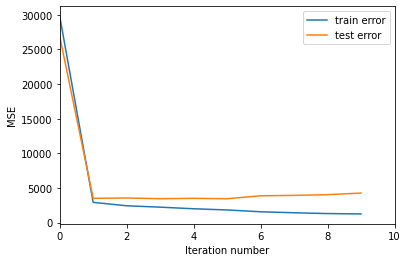

In [133]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев

In [146]:
%%time
n_trees = 50
eta = 1

trees_1, train_errors_1, test_errors_1 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 1min 55s, sys: 1.34 s, total: 1min 56s
Wall time: 2min 11s


In [147]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_1, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 0.0018199566554480773
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 1 на тестовой выборке: 5827.966433745808


In [ ]:
# get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [148]:
%%time
n_trees = 50
eta = 0.1

trees_01, train_errors_01, test_errors_01 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 1min 41s, sys: 1.06 s, total: 1min 42s
Wall time: 1min 43s


In [149]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_01, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 292.87778620802044
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3293.5437646978794


In [ ]:
# get_error_plot(n_trees, train_errors, test_errors)

In [150]:
%%time
n_trees = 50
eta = 0.01

trees_001, train_errors_001, test_errors_001 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 1min 50s, sys: 1.18 s, total: 1min 51s
Wall time: 2min 2s


In [151]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_001, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.01 на тренировочной выборке: 11931.331587373485
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 11173.18075240145


In [216]:
def get_error_plot(n_trees, train_errors_1, test_errors_1, train_errors_01, test_errors_01, train_errors_001, test_errors_001):
  plt.figure(figsize=(10, 10))
  plt.xlabel('Число деревьев')
  plt.ylabel('MSE')
  # plt.xlim(0, n_trees)
  plt.plot(list(range(n_trees)), train_errors_1, label='train eta=1')
  plt.plot(list(range(n_trees)), test_errors_1, label='test eta=1')
  plt.plot(list(range(n_trees)), train_errors_01, label='train eta=0.1')
  plt.plot(list(range(n_trees)), test_errors_01, label='test eta=0.1')
  plt.plot(list(range(n_trees)), train_errors_001, label='train eta=0.01')
  plt.plot(list(range(n_trees)), test_errors_001, label='test eta=0.01')
  plt.legend(loc='upper right')
  plt.show()

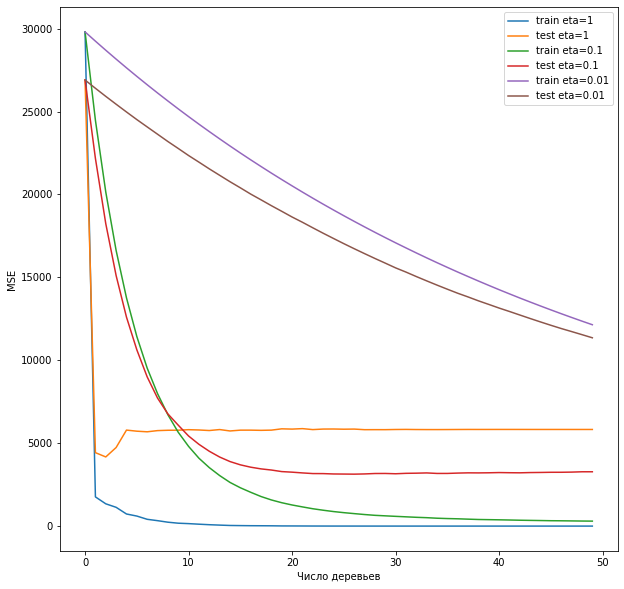

In [217]:
get_error_plot(n_trees, train_errors_1, test_errors_1, train_errors_01, test_errors_01, train_errors_001, test_errors_001)

In [218]:
%%time
eta = 0.1
max_depth = 1

trees_1, train_errors_1, test_errors_1 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 2min 2s, sys: 1.2 s, total: 2min 3s
Wall time: 2min 24s


In [219]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_1, eta)

Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 2735.215645649808
Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 2953.479372977196


In [220]:
%%time
eta = 0.1
max_depth = 2

trees_2, train_errors_2, test_errors_2 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 1min 51s, sys: 1.2 s, total: 1min 52s
Wall time: 2min 4s


In [221]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_2, eta)

Ошибка алгоритма из 50 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 2045.0612268196858
Ошибка алгоритма из 50 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 2938.9497375695937


In [222]:
%%time
eta = 0.1
max_depth = 3

trees_3, train_errors_3, test_errors_3 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 1min 47s, sys: 1.39 s, total: 1min 49s
Wall time: 1min 49s


In [223]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_3, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1472.814863952287
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3100.7322817049985


In [224]:
%%time
eta = 0.1
max_depth = 4

trees_4, train_errors_4, test_errors_4 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 1min 42s, sys: 1.19 s, total: 1min 43s
Wall time: 1min 42s


In [225]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_4, eta)

Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 810.7749871090354
Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 3269.6218042303085


In [227]:
%%time
eta = 0.1
max_depth = 5

trees_5, train_errors_5, test_errors_5 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 1min 43s, sys: 1.12 s, total: 1min 44s
Wall time: 1min 43s


In [228]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_5, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 292.87778620802044
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3293.5437646978794


In [239]:
def get_error_plot(n_trees, train_errors_1, test_errors_1, 
                   train_errors_2, test_errors_2, 
                   train_errors_3, test_errors_3,
                   train_errors_4, test_errors_4,
                   train_errors_5, test_errors_5
                   ):
  plt.figure(figsize=(10, 10))
  plt.xlabel('Число деревьев')
  plt.ylabel('MSE')
  plt.xlim(0, n_trees)
  plt.plot(list(range(n_trees)), train_errors_1, label='train depth=1')
  plt.plot(list(range(n_trees)), test_errors_1, label='test depth=1')
  plt.plot(list(range(n_trees)), train_errors_2, label='train depth=2')
  plt.plot(list(range(n_trees)), test_errors_2, label='test depth=2')
  plt.plot(list(range(n_trees)), train_errors_3, label='train depth=3')
  plt.plot(list(range(n_trees)), test_errors_3, label='test depth=3')
  plt.plot(list(range(n_trees)), train_errors_4, label='train depth=4')
  plt.plot(list(range(n_trees)), test_errors_4, label='test depth=4')
  plt.plot(list(range(n_trees)), train_errors_5, label='train depth=5')
  plt.plot(list(range(n_trees)), test_errors_5, label='test depth=5')
  plt.legend(loc='upper right')
  plt.show()

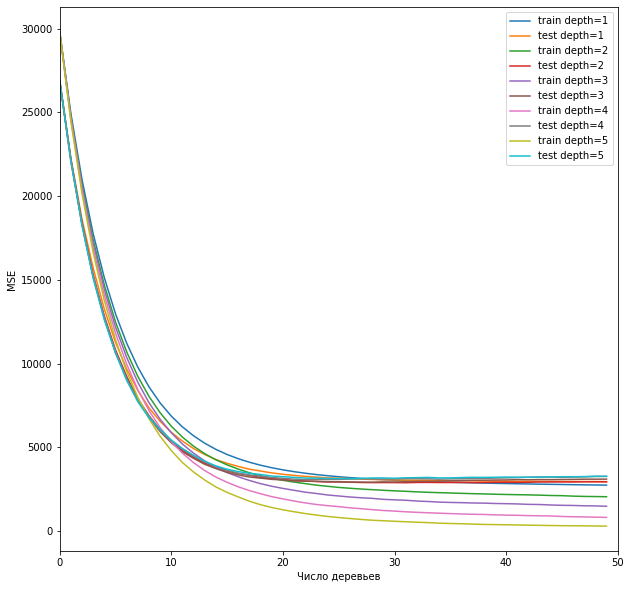

In [240]:
get_error_plot(n_trees, train_errors_1, test_errors_1, 
                   train_errors_2, test_errors_2, 
                   train_errors_3, test_errors_3,
                   train_errors_4, test_errors_4,
                   train_errors_5, test_errors_5)

Ошибка на обучающей выборке упала, а на тестовой несколько поднялась, то есть в данном случае можем говорить о появлении переобучения.

В целом, тут мы показали, что варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели.